In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
​
param_distrib = {"max_depth": randint(1, 50),
              "max_features": randint(1, 16),
                 "min_samples_leaf": randint(2, 1000),
              "min_samples_split": randint(2, 1000),
                }
​
clf = RandomizedSearchCV(RandomForestClassifier(), param_distrib, n_iter=1000)

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import itertools
import helper_functions as hlf

from scipy.stats import randint
from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
# open the pre-processed csv file and split the target variable from the classifiers
df = pd.read_csv('dota2_scaled.csv')

# Shuffle the dataframe before the train test split  
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
#separate the target variable
labels = df['Won']
df.drop(['Won'], axis=1, inplace=True)

In [ ]:
def print_metrics(labels, predictions, print_score=None):
    ''' This function receives model predictions along with the actual labels
        and returns the precision score, recall, accuracy and F1'''
    
    recall = round(recall_score(labels, predictions)*100, 2)
    acc = round(accuracy_score(labels, predictions)*100, 2)
    
    if print_score:
        print(f"Recall Score: {recall}")
        print(f"Accuracy Score: {acc}")
        
    return recall, acc

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    plt.matshow(matrix,  cmap=plt.cm.RdYlBu, aspect=1.75, alpha=0.5)

    #Add title and Axis Labels
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    #Add appropriate Axis Scales
    class_names = ['Lose', 'Win']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.grid(b=None)
    
    #Add Labels to Each Cell
    thresh = matrix.max() / 2. #Used for text coloring below
    
    #iterate through the confusion matrix and append the labels
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
            plt.text(j, i, matrix[i, j],
                     horizontalalignment="center",
                     color="black" if matrix[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    return

In [4]:
# Create seprate training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.25)

In [24]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='stratified', random_state=123)
dummy.fit(x_train, y_train)

dummy_pred = dummy.predict(x_test)
hlf.print_metrics(y_test, dummy_pred)

(49.59, 50.15)

#   KNN Model:

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# run initial model with default values
knn = KNeighborsClassifier()
knn.fit(x_train, y_train.values.ravel())

knn_pred = knn.predict(x_test)

k5recall, k5acc = hlf.print_metrics(y_test, knn_pred, print_score=True)

Recall Score: 100.0
Accuracy Score: 100.0


In [ ]:
hlf.plot_confusion_matrix(y_test, knn_pred)

## Initial KNN model performed too good 
Recall Score: 100%

Accuracy Score: 100%

In [31]:
def multiple_knn(df, labels, ks=[5]):
    x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.2)
    best_acc = 0
    best_k = 0
    scores = []

    for k in tqdm(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train.values.ravel())
        test_predict = knn.predict(x_test)
        score = hlf.print_metrics(y_test, test_predict)
        scores.append(score)
        
        if best_acc < score[1]:
            best_acc = score[1]
            best_k = k
            
        
    return best_acc, best_k, scores

In [34]:
# run model again k = 1, 5, 6, 7
acc, k, scores = multiple_knn(df, labels, ks=[1, 5, 6, 7])
print(f"scores: {scores}, k: {k}")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


scores: [(100.0, 99.98), (100.0, 99.98), (100.0, 99.98), (100.0, 99.98)], k: 1


### KNN = 4


#### Recall - 42.94% 

#### Accuracy = 52.24%


In [ ]:
# run KNN again with k neighbots 
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train, y_train.values.ravel())

# predict
k14_predict = knn.predict(x_test)

# test how the model performed
k14_recall, k14_acc = print_metrics(y_test, k14_predict, print_score=True)

# plot confusion matrix
plot_confusion_matrix(y_test, k14_predict)

# Decision Trees

In [7]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

D:\Programs\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [9]:
tree = DecisionTreeClassifier(random_state=10)  
tree.fit(x_train, y_train)

# predict
tree_pred = tree.predict(x_test)

# get prediction accuracy
tree_recall, tree_acc = hlf.print_metrics(y_test, tree_pred, print_score=True)

Recall Score: 100.0
Accuracy Score: 100.0


NameError: name 'itertools' is not defined

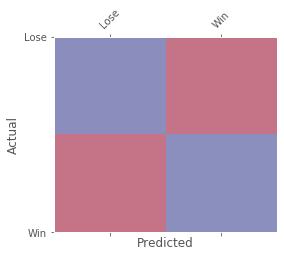

In [16]:
hlf.plot_confusion_matrix(y_test, tree_pred)

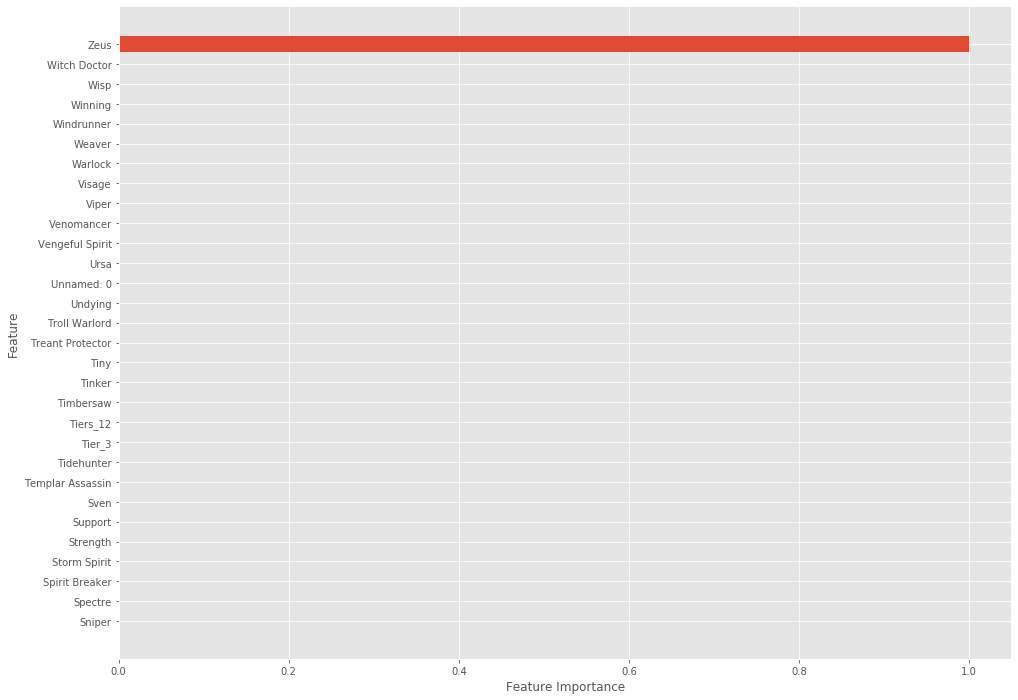

In [15]:
hlf.plot_feature_importance(tree, x_train, n=30)

In [ ]:
# Identify the optimal tree depth for given data
def find_optimal_depth(x_train, x_test, y_train, y_test):   
    #declare variables
    max_depths = np.linspace(1, 20, 20, endpoint=True)
    train_results = []
    test_results = []
    # iterate over the different depths
    for depth in max_depths:
        trees = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        trees.fit(x_train, y_train)
        
        # Add auc score to train list
        train_pred = trees.predict(x_train)
        fpr, tpr, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(fpr, tpr)
        train_results.append(roc_auc)
        
        # Add auc score to test list
        test_pred = trees.predict(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, test_pred)
        roc_auc = auc(fpr, tpr)
        test_results.append(roc_auc)
        
    plt.figure(figsize=(12,6))
    plt.plot(max_depths, train_results, 'b', label='Train AUC')
    plt.plot(max_depths, test_results, 'r', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.legend()
    plt.show()
    pass

In [ ]:
# find the optimal depth to narrow down search and avoid over fitting
find_optimal_depth(x_train, x_test, y_train, y_test)

In [ ]:
tree_param_grid = {'criterion': ['entropy'],
                  'max_depth': [5],
                  'min_samples_split': [3, 5, 6, 7, 8, 9, 12],
                  'min_samples_leaf': [2,3, 4, 5, 6, 7, 8, 12]
                  }               

tree_gs = GridSearchCV(tree, param_grid=tree_param_grid, scoring='accuracy', cv=4)
tree_grid = tree_gs.fit(x_train, y_train.values.ravel())

In [ ]:
# fit the optimal tree
optimal_tree = tree_grid.best_estimator_
optimal_tree.fit(x_train, y_train)
# predict
opt_tree_pred = optimal_tree.predict(x_test)

# get prediction accuracy
opt_tree_recall, opt_tree_acc = print_metrics(y_test, opt_tree_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, opt_tree_pred)

In [ ]:
plot_feature_importance(optimal_tree, x_test)

In [ ]:
print(tree_grid.best_params_)

### Optimal Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 12}

#### Recall - 46.31% 

#### Accuracy = 55.45%

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [13]:
# get a baseline how random forest performs
forest = RandomForestClassifier(random_state=1234)
forest.fit(x_train, y_train.values.ravel())

# predcit
forest_test_pred = forest.predict(x_test)

# testing accuracy
f_recall, f_acc = hlf.print_metrics(y_test, forest_test_pred, print_score=True)

D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Recall Score: 99.76
Accuracy Score: 99.88


### Random Forest Using Gridsearch

In [ ]:
# define params grid
forest_param_grid = {'criterion': ['gini', 'entropy'],
                     'max_depth': [5, 6, 7],
                     'min_samples_split': [6, 7, 10, 12, 18],
                     'min_samples_leaf': [2, 3, 9, 12, ]
                    }                    

In [ ]:
# Use grid search to find the best paramers for random forest
forest_search = GridSearchCV(forest, forest_param_grid, cv=3, verbose=1, scoring='accuracy')
forest_search.fit(x_train, y_train.values.ravel())

# predcit the testing data
forest_grid_test_pred = forest_search.predict(x_test)

# test how the model performs 
forest_grid_recall, forest_grid_acc = print_metrics(y_test, forest_grid_test_pred, print_score=True)

#best paramters
print(f"Best paramaters: {best_forest_params}")

In [ ]:
# fit the optimal random forest
optimal_forest = forest_search.best_estimator_
optimal_forest.fit(x_train, y_train)
# predict
opt_forest_pred = optimal_forest.predict(x_test)

# get prediction accuracy
opt_forest_recall, opt_forest_acc = print_metrics(y_test, opt_forest_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, opt_forest_pred)

In [ ]:
plot_feature_importance(optimal_forest, x_test)

### Optimal Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 6}

#### Recall Score: 53.24

#### Accuracy Score: 55.83

# AdaBoost

In [ ]:
# get a baseline on how ada boost performs
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train.values.ravel())

# predict
adaboost_test_pred = adaboost.predict(x_test)

# test how the model performs 
ada_recall, ada_accuracy = print_metrics(y_test, adaboost_test_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, adaboost_test_pred)

### AdaBoost Using Gridsearch

In [ ]:
adaboost_param_grid = {'n_estimators': [70, 150, 200, 250, 270, 300],
                       'learning_rate': [0.4, 0.2, 0.1]
                      }

In [ ]:
#fit adaboost with a paramters grid
ada_grid_search = GridSearchCV(adaboost, adaboost_param_grid, scoring='accuracy', cv=4)
ada_grid_search.fit(x_train, y_train.values.ravel())

# predict 
adagrid_pred = ada_grid_search.predict(x_test)

# test how well the model performs 
adagrid_recall, adagrid_accuracy = print_metrics(y_test, adagrid_pred, print_score=True)

#best paramters
best_ada_params = ada_grid_search.best_params_

In [ ]:
print(best_ada_params)

In [ ]:
# changing the hyper paramaters grid
adaboost_param_grid2 = {'n_estimators': [50, 125, 150, 175, 200],
                        'learning_rate': [0.1, 0.2, 0.3]
                       }

# fitting a new model with different hyper paramaters
ada_grid_search2 = GridSearchCV(adaboost, adaboost_param_grid2, scoring='accuracy', cv=4)
ada_grid_search2.fit(x_train, y_train.values.ravel())

# predict 
adagrid_pred2 = ada_grid_search2.predict(x_test)

# test how well the model performs 
adagrid_recall2, adagrid_accuracy2 = print_metrics(y_test, adagrid_pred2, print_score=True)

#best paramters
print(best_ada_params2)

In [ ]:
# fit the optimal paramaters for adaboost
optimal_ada = ada_grid_search2.best_estimator_
optimal_ada.fit(x_train, y_train)
# predict
opt_ada_pred = optimal_ada.predict(x_test)

# get prediction accuracy
opt_ada_recall, opt_ada_acc = print_metrics(y_test, opt_ada_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, opt_ada_pred)

In [ ]:
plot_feature_importance(optimal_ada, x_test)

### Optimal Parameters: {learning_rate': 0.4, 'n_estimators': 150}
#### Score = 56.36%

# XGBoost

In [ ]:
import xgboost as xgb

# check baseline accuracy for xgboost
xgbooster = xgb.XGBClassifier()
xgbooster.fit(x_train, y_train.values.ravel())

# predict
xgb_pred = xgbooster.predict(x_test)

# test how well the model performs 
xgb_recall, xgb_accuracy = print_metrics(y_test, xgb_pred, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, xgb_pred)

In [ ]:
plot_feature_importance(xgbooster, x_train, n=30)

### XGBoost Using Gridsearch

In [ ]:
xg_param_grid = {'learning_rate': [0.2], 'max_depth': [6, 7, 8], 
                 'min_child_weight': [4, 5, 6], 'subsample': [0.6, 0.7, 0.8],
                 'n_estimators': [100, 120, 150]
                }

In [ ]:
xg_grid = GridSearchCV(xgbooster, xg_param_grid, scoring='accuracy', cv=3, n_jobs=1)
xg_grid.fit(x_train, y_train.values.ravel())


# predict
xg_grid_preds = xg_grid.predict(x_test)

# test how well the model performs 
xg_grid_recall, xg_grid_acc = print_metrics(y_test, xg_grid_preds, print_score=True)
best_parameters = xg_grid.best_params_

print(best_parameters)

In [ ]:
# run xgboost again with the new paramaters
xgbooster2 = xg_grid.best_estimator_
xgbooster2.fit(x_train, y_train.values.ravel())

# predict
xgb_pred2 = xgbooster.predict(x_test)

# test how well the model performs 
xgb_recall2, xgb_accuracy2 = print_metrics(y_test, xgb_pred2, print_score=True)

In [ ]:
plot_confusion_matrix(y_test, xgb_pred2)

In [ ]:
def log_roc_curve(model, x_test, y_test):
    scores = model.decision_function(x_test)
    
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    
    # plot the roc curve
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC Curve')
    
    # plot the line through the origin of axis
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    
    # add graph labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    return auc_score

In [ ]:
def plot_feature_importance(model, x_train, n=30):
    """ This function recievies a model and plots the 'n' most important features"""
    # extract and sort the feature importance
    features = model.feature_importances_
    columns = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, columns])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
     # plot the features
    plt.figure(figsize=(16, 12))
    plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

In [ ]:
plot_feature_importance(xgbooster2, x_train, n=30)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# check the baseline how logistic regression works
log_reg = LogisticRegression(fit_intercept = False, C = 1e12) #Starter code
log_mod = log_reg.fit(x_train, y_train)

# predict
log_pred = log_reg.predict(x_test)

# test how well the model performs 
log_recall, log_acc = print_metrics(y_test, log_pred, print_score=True)

### Logistic regression using Gridsearch

In [ ]:
log_grid = {"C": np.logspace(0, 4, 7), "penalty": ["l1", "l2"]}

log_reg_grid = GridSearchCV(log_mod, log_grid, scoring="accuracy", cv=4)
log_reg_grid = log_reg_grid.fit(x_train, y_train.values.ravel())

# predict
grid_log_pred = log_reg.predict(x_test)

# test how well the model performs 
grid_log_recall, grid_log_acc = print_metrics(y_test, grid_log_pred, print_score=True)

In [ ]:
log_reg_grid.best_score_

In [ ]:
log_reg_grid.best_params_

In [ ]:
log2_mod = log_reg_grid.best_estimator_
log2_mod.fit(x_train, y_train)

log2_pred = log2_mod.predict(x_test)
# test how well the model performs 
log2_recall, log2_acc = print_metrics(y_test, log2_pred, print_score=True)
log2_mod.score(x_test, y_test)

In [ ]:
log_roc_curve(log2_mod, x_test, y_test)

In [ ]:
plot_confusion_matrix(y_test, log2_pred)

# SVM


In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# Reduce dimonsionality so my computer won't explode trying to run SVM with 30k observations and 114 dimensions
x_reduced = PCA(n_components=30).fit_transform(df)

In [ ]:
rx_train, rx_test, ry_train, ry_test = train_test_split(x_reduced, labels,
                                                        test_size=0.25,
                                                        random_state=123)


In [ ]:
# to get a base line run model with default paramters and different kernels
SVMp = SVC(kernel='poly', max_iter=3500)
SVMp.fit(rx_train, ry_train)
print(SVMp.score(rx_test, ry_test))

In [ ]:
# to get a base line run model with default paramters and different kernels
SVMs = SVC(kernel='rbf', max_iter=3500)
SVMs.fit(rx_train, ry_train)
print(SVMs.score(rx_test, ry_test))

In [ ]:
# to get a base line run model with default paramters
SVM = LinearSVC(max_iter=3500)
SVM.fit(rx_train, ry_train)
print(SVM.score(rx_test, ry_test))

### LinearSVC using Gridsearch

In [ ]:
c = np.logspace(start=-5, stop=400, base=1.05)
svm_grid = {'C': c}

svm_grid = GridSearchCV(SVM, param_grid=svm_grid, cv=4, n_jobs=-1, scoring='accuracy')
svm_grid.fit(rx_train, ry_train)

In [ ]:
opt_svm = svm_grid.best_estimator_
opt_svm.fit(rx_train, ry_train)

# predict
opt_svm_pred = opt_svm.predict(rx_test)

# check how badly the model predicts
opt_svm_recall, opt_svm_acc = print_metrics(ry_test, opt_svm_pred, print_score=True)
opt_svm.score(rx_test, ry_test)

In [ ]:
# changing the penalty from 'l2' to 'l1' and check how badly the model predicts
SVMl1 = LinearSVC(penalty='l1', max_iter=3500, dual=False)

svml1_grid = GridSearchCV(SVMl1, param_grid=svm_grid, cv=4, n_jobs=-1, scoring='accuracy')
svml1_grid.fit(rx_train, ry_train)

In [ ]:
optl1_svm = svml1_grid.best_estimator_
optl1_svm.fit(rx_train, ry_train)

# predict
opt_svml1_pred = optl1_svm.predict(rx_test)

# test how well the model performs 
opt_svml1_recall, opt_svml1_acc = print_metrics(ry_test, opt_svml1_pred, print_score=True)
optl1_svm.score(rx_test, ry_test)